In [5]:
'''
Importa os módulos usados
'''
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

class Struct:
    pass

def wrap_struct(solution):
    x = Struct()
    x.solution = solution
    return x

# Leitura dos dados
path_equip = 'Dados/EquipDB.csv'
path_planos = 'Dados/MPDB.csv'
path_cluster = 'Dados/ClusterDB.csv'

Equipamentos = pd.read_csv(path_equip, header=None, names=["ID", "t0", "cluster", "custo de falha"])
Planos = pd.read_csv(path_planos, header=None, names=["ID", "k", "custo"])
ModeloFalha = pd.read_csv(path_cluster, header=None, names=["ID", "eta", "beta"])

# Solução inicial aleatória
def Sol_Inicial(equipamentos):
    return np.random.randint(1, 4, size=len(equipamentos))

# Estrutura de dados
def manutencao_def(equipamentos, planos):
    dados = Struct()
    dados.equipamentos = equipamentos
    dados.planos = planos.set_index("ID")
    dados.modelo_falha = ModeloFalha.set_index("ID")
    dados.n = len(equipamentos)
    dados.custo_por_plano = dados.planos["custo"].to_dict()
    return dados

# Funções objetivo
def fobj_f1(x, dados):
    custo_total = sum(dados.custo_por_plano[plano] for plano in x.solution)
    x.fitness = custo_total
    return x

def fobj_f2(x, dados):
    custo = 0
    for i, plano in enumerate(x.solution):
        eq = dados.equipamentos.iloc[i]
        cluster = dados.modelo_falha.loc[eq["cluster"]]
        plano_info = dados.planos.loc[plano]

        t0 = eq["t0"]
        k = plano_info["k"]
        delta_t = 5
        eta = cluster["eta"]
        beta = cluster["beta"]

        Fi = lambda t: 1 - np.exp(-(t / eta)**beta)
        pi = (Fi(t0 + k * delta_t) - Fi(t0)) / (1 - Fi(t0))
        custo += pi * eq["custo de falha"]

    x.fitness = custo
    return x

# Soma ponderada
def soma_ponderada(x, dados, peso_f1):
    peso_f2 = 100 - peso_f1
    f1 = fobj_f1(copy.deepcopy(x), dados).fitness
    f2 = fobj_f2(copy.deepcopy(x), dados).fitness
    
    # Normalização (ajuste os valores de referência conforme necessário)
    ref_f1 = 1049  # Referência para f1 (custo total de manutenção)
    ref_f2 = 1744  # Referência para f2 (custo total de falha)
    
    f1_norm = f1 / ref_f1
    f2_norm = f2 / ref_f2
    
    x.fitness = (f1_norm * peso_f1 + f2_norm * peso_f2) / 100
    return x

# Operadores de vizinhança
def shake(x, r, planos=3):
    y = copy.deepcopy(x)
    indices = np.random.permutation(len(x.solution))[:r]
    for idx in indices:
        plano_atual = y.solution[idx]
        opcoes = [p for p in range(1, planos+1) if p != plano_atual]
        y.solution[idx] = np.random.choice(opcoes)
    return y

def shake_adiciona(x, r):
    y = copy.deepcopy(x)
    indices = np.random.permutation(len(y.solution))[:r]
    for idx in indices:
        if y.solution[idx] < 3:
            y.solution[idx] += 1
    return y

def shake_subtrai(x, r):
    y = copy.deepcopy(x)
    indices = np.random.permutation(len(y.solution))[:r]
    for idx in indices:
        if y.solution[idx] > 1:
            y.solution[idx] -= 1
    return y

# Algoritmo RVNS otimizado
def rvns_otimizado(fobj, sol_inicial, shake, max_num_sol_avaliadas, r=10, kmax=3):
    x = wrap_struct(sol_inicial())
    x = fobj(x)
    
    num_sol_avaliadas = 1
    historico = [x.fitness]
    best = copy.deepcopy(x)
    historico_best = [best.fitness]

    estruturas_vizinhanca = [shake_adiciona, shake_subtrai, shake]

    while num_sol_avaliadas < max_num_sol_avaliadas:
        k = 1
        while k <= kmax and num_sol_avaliadas < max_num_sol_avaliadas:
            for shake_func in estruturas_vizinhanca:
                if num_sol_avaliadas >= max_num_sol_avaliadas:
                    break
                    
                y = shake_func(x, r)
                y = fobj(y)
                num_sol_avaliadas += 1
                historico.append(x.fitness)
                
                if y.fitness < best.fitness:
                    best = copy.deepcopy(y)
                historico_best.append(best.fitness)

                if y.fitness < x.fitness:
                    x = copy.deepcopy(y)
                    break
            else:
                k += 1

    return best, historico

# Gera a fronteira de Pareto

def gerar_fronteira_pareto(dados, num_pontos=20, max_iteracoes=100):
    pesos = np.linspace(0, 100, num_pontos)
    resultados_f1 = []
    resultados_f2 = []
    
    for peso in pesos:
        print(f"Otimizando para peso f1 = {peso:.1f}, f2 = {100 - peso:.1f}")
        
        def fobj_personalizada(x):
            return soma_ponderada(x, dados, peso)
        
        best, _ = rvns_otimizado(
            fobj=fobj_personalizada,
            sol_inicial=lambda: Sol_Inicial(Equipamentos),
            shake=shake,
            max_num_sol_avaliadas=max_iteracoes,
            r=10,
            kmax=3
        )
        
        f1 = fobj_f1(copy.deepcopy(best), dados).fitness
        f2 = fobj_f2(copy.deepcopy(best), dados).fitness
        
        resultados_f1.append(f1)
        resultados_f2.append(f2)
    
    return resultados_f1, resultados_f2


''''
# Execução principal
if __name__ == "__main__":
    dados = manutencao_def(Equipamentos, Planos)
    
    print("\n--- GERANDO FRONTEIRA DE PARETO ---\n")
    resultados_f1, resultados_f2 = gerar_fronteira_pareto(dados, num_pontos=200, max_iteracoes=50)
    
    # Gráfico da fronteira de Pareto
    plt.figure(figsize=(10, 6))
    plt.scatter(resultados_f2, resultados_f1, c='blue', label='Soluções')
    plt.title("Fronteira de Pareto Aproximada")
    plt.xlabel("Custo de Falha (F2)")
    plt.ylabel("Custo de Manutenção (F1)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    '''

'\'\n# Execução principal\nif __name__ == "__main__":\n    dados = manutencao_def(Equipamentos, Planos)\n\n    print("\n--- GERANDO FRONTEIRA DE PARETO ---\n")\n    resultados_f1, resultados_f2 = gerar_fronteira_pareto(dados, num_pontos=200, max_iteracoes=50)\n\n    # Gráfico da fronteira de Pareto\n    plt.figure(figsize=(10, 6))\n    plt.scatter(resultados_f2, resultados_f1, c=\'blue\', label=\'Soluções\')\n    plt.title("Fronteira de Pareto Aproximada")\n    plt.xlabel("Custo de Falha (F2)")\n    plt.ylabel("Custo de Manutenção (F1)")\n    plt.grid(True)\n    plt.legend()\n    plt.tight_layout()\n    plt.show()\n    '


Gerando fronteira com ϵ-restrito (min F1)...
Calculando soluções extremas para determinar faixa de epsilon...

Otimizando com epsilon = 1124.48 (Progresso: 1/20)
Solução inválida encontrada para eps=1124.48 - descartando

Otimizando com epsilon = 1145.46 (Progresso: 1/20)

Otimizando com epsilon = 1166.82 (Progresso: 2/20)

Otimizando com epsilon = 1188.59 (Progresso: 3/20)

Otimizando com epsilon = 1210.76 (Progresso: 4/20)

Otimizando com epsilon = 1233.34 (Progresso: 5/20)

Otimizando com epsilon = 1256.35 (Progresso: 6/20)

Otimizando com epsilon = 1279.79 (Progresso: 7/20)

Otimizando com epsilon = 1303.66 (Progresso: 8/20)

Otimizando com epsilon = 1327.98 (Progresso: 9/20)

Otimizando com epsilon = 1352.75 (Progresso: 10/20)

Otimizando com epsilon = 1377.98 (Progresso: 11/20)

Otimizando com epsilon = 1403.68 (Progresso: 12/20)

Otimizando com epsilon = 1429.87 (Progresso: 13/20)

Otimizando com epsilon = 1456.54 (Progresso: 14/20)

Otimizando com epsilon = 1483.71 (Progresso:

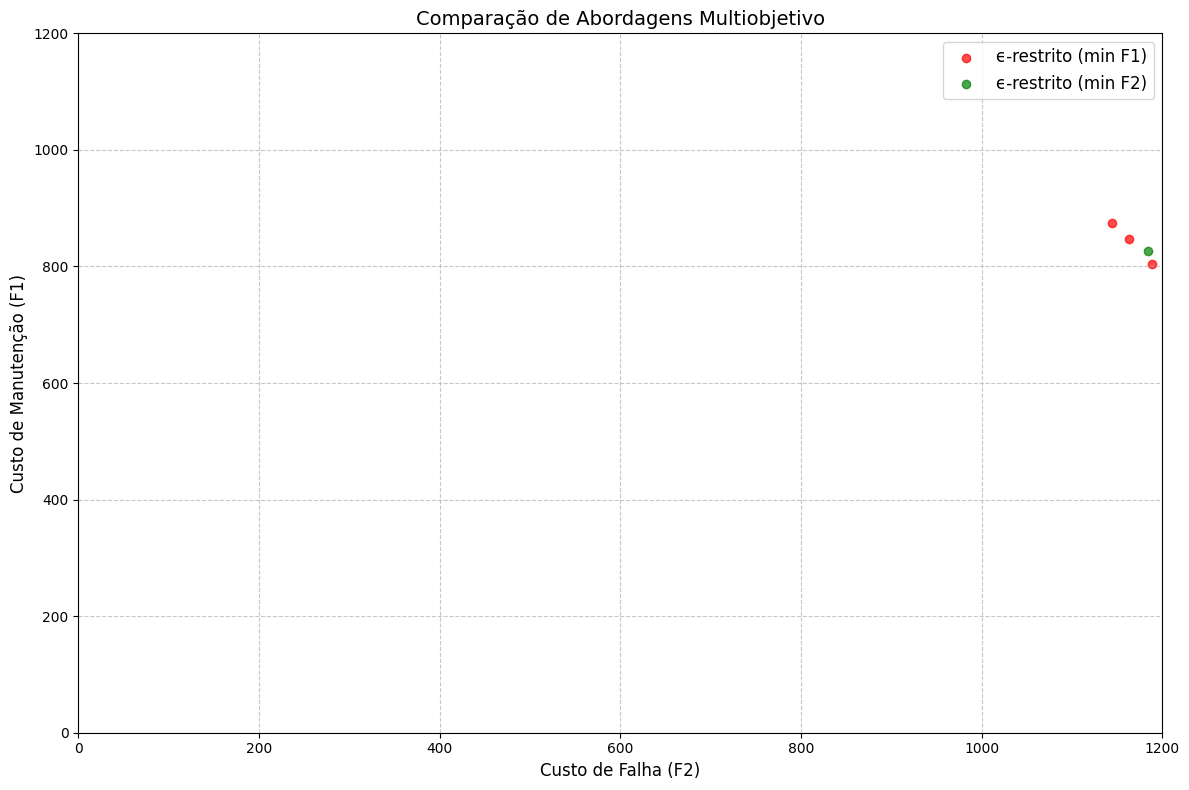

In [ ]:
def fobj_epsilon_restrito(x, dados, epsilon, objetivo_principal='f1'):
    """
    Função objetivo ϵ-restrito aprimorada.
    
    Args:
        x: Solução candidata
        dados: Dados do problema
        epsilon: Valor limite para a função objetivo restrita
        objetivo_principal: Qual função será otimizada ('f1' ou 'f2')
    
    Returns:
        x com fitness calculado (com penalização adaptativa se violar a restrição)
    """
    # Calcula ambos os objetivos uma única vez
    f1 = fobj_f1(copy.deepcopy(x), dados).fitness
    f2 = fobj_f2(copy.deepcopy(x), dados).fitness
    
    if objetivo_principal == 'f1':
        # Minimiza f1 sujeito a f2 <= epsilon
        if f2 <= epsilon:
            x.fitness = f1
        else:
            # Penalização adaptativa proporcional à violação
            violacao = f2 - epsilon
            x.fitness = f1 + 1e6 * violacao  # Fator grande para garantir dominância
    else:
        # Minimiza f2 sujeito a f1 <= epsilon
        if f1 <= epsilon:
            x.fitness = f2
        else:
            violacao = f1 - epsilon
            x.fitness = f2 + 1e6 * violacao
    
    return x

def gerar_fronteira_epsilon(dados, num_pontos=20, max_iteracoes=100, objetivo_principal='f1'):
    """
    Gera fronteira Pareto usando abordagem ϵ-restrito aprimorada.
    
    Args:
        objetivo_principal: 'f1' para minimizar custo manutenção,
                          'f2' para minimizar custo falha
    """
    # Primeiro obtemos os valores extremos de forma mais eficiente
    print("Calculando soluções extremas para determinar faixa de epsilon...")
    
    # Cache para evitar recálculos
    extremos_cache = {}
    
    def calcular_extremos():
        if not extremos_cache:
            # Solução que minimiza f1
            best_f1, _ = rvns_otimizado(
                fobj=lambda x: fobj_f1(x, dados),
                sol_inicial=lambda: Sol_Inicial(Equipamentos),
                shake=shake,
                max_num_sol_avaliadas=max_iteracoes
            )
            # Solução que minimiza f2
            best_f2, _ = rvns_otimizado(
                fobj=lambda x: fobj_f2(x, dados),
                sol_inicial=lambda: Sol_Inicial(Equipamentos),
                shake=shake,
                max_num_sol_avaliadas=max_iteracoes
            )
            
            extremos_cache.update({
                'min_f1': best_f1.fitness,
                'max_f2': fobj_f2(copy.deepcopy(best_f1), dados).fitness,
                'max_f1': fobj_f1(copy.deepcopy(best_f2), dados).fitness,
                'min_f2': best_f2.fitness
            })
        return extremos_cache
    
    extremos = calcular_extremos()
    
    # Gera valores de epsilon com distribuição logarítmica para melhor cobertura
    if objetivo_principal == 'f1':
        epsilons = np.logspace(np.log10(extremos['min_f2']), 
                              np.log10(extremos['max_f2']), 
                              num_pontos)
    else:
        epsilons = np.logspace(np.log10(extremos['min_f1']), 
                              np.log10(extremos['max_f1']), 
                              num_pontos)
    
    resultados_f1 = []
    resultados_f2 = []
    solucoes_validas = 0
    
    for eps in epsilons:
        print(f"\nOtimizando com epsilon = {eps:.2f} (Progresso: {len(resultados_f1)+1}/{num_pontos})")
        
        def fobj(x):
            return fobj_epsilon_restrito(x, dados, eps, objetivo_principal)
        
        best, _ = rvns_otimizado(
            fobj=fobj,
            sol_inicial=lambda: Sol_Inicial(Equipamentos),
            shake=shake,
            max_num_sol_avaliadas=max_iteracoes,
            r=max(5, int(len(Equipamentos)*0.02)),  # Vizinhanca proporcional ao tamanho
            kmax=3
        )
        
        # Verifica se a solução é válida (não viola a restrição)
        f1 = fobj_f1(copy.deepcopy(best), dados).fitness
        f2 = fobj_f2(copy.deepcopy(best), dados).fitness
        
        if (objetivo_principal == 'f1' and f2 <= eps) or (objetivo_principal == 'f2' and f1 <= eps):
            solucoes_validas += 1
            resultados_f1.append(f1)
            resultados_f2.append(f2)
        else:
            print(f"Solução inválida encontrada para eps={eps:.2f} - descartando")
    
    print(f"\nEstatísticas:")
    print(f"- Total de pontos tentados: {num_pontos}")
    print(f"- Soluções válidas encontradas: {solucoes_validas} ({solucoes_validas/num_pontos:.1%})")
    
    return resultados_f1, resultados_f2

# Função para plotar resultados comparativos
def plotar_resultados_comparativos(dados, num_pontos=20, max_iteracoes=100):
    # Gerar fronteiras com diferentes abordagens
    # print("\nGerando fronteira com Soma Ponderada...")
    #f1_pw, f2_pw = gerar_fronteira_pareto(dados, num_pontos, max_iteracoes)
    
    print("\nGerando fronteira com ϵ-restrito (min F1)...")
    f1_eps1, f2_eps1 = gerar_fronteira_epsilon(dados, num_pontos, max_iteracoes, 'f1')
    
    print("\nGerando fronteira com ϵ-restrito (min F2)...")
    f1_eps2, f2_eps2 = gerar_fronteira_epsilon(dados, num_pontos, max_iteracoes, 'f2')
    
    # Plot comparativo
    plt.figure(figsize=(12, 8))
    
    # Soma ponderada
    # plt.scatter(f2_pw, f1_pw, c='blue', marker='o', label='Soma Ponderada', alpha=0.7)
    
    # ϵ-restrito (min f1)
    plt.scatter(f2_eps1, f1_eps1, c='red', marker='o', label='ϵ-restrito (min F1)', alpha=0.7)
    
    # ϵ-restrito (min f2)
    plt.scatter(f2_eps2, f1_eps2, c='green', marker='o', label='ϵ-restrito (min F2)', alpha=0.7)
    
    plt.title("Comparação de Abordagens Multiobjetivo", fontsize=14)
    plt.xlabel("Custo de Falha (F2)", fontsize=12)
    plt.ylabel("Custo de Manutenção (F1)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    # Adiciona valores extremos
    
    plt.xlim(0, 1200)
    plt.ylim(0, 4000)
    
    plt.tight_layout()
    plt.show()

# Execução principal
if __name__ == "__main__":
    dados = manutencao_def(Equipamentos, Planos)
    plotar_resultados_comparativos(dados, num_pontos=20, max_iteracoes=100)